# Video Analysis - Heatmap e Visualizações

Este notebook analisa os resultados da detecção de objetos e gera visualizações como heatmaps e gráficos de densidade.

Compatível com os outputs do `videos_inference.py`:
- Arquivos JSON (dados completos com confiança e classes)
- Arquivos TXT (apenas coordenadas)
- Análise de vídeo único ou múltiplos vídeos
- Sumário consolidado

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from pathlib import Path
from typing import Dict, List, Tuple

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Funções de Carregamento de Dados

In [ ]:
def load_from_json(json_path: Path) -> Dict:
    """Carrega dados de um arquivo JSON."""
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)


def load_from_txt(txt_path: Path) -> Tuple[List[float], List[float]]:
    """
    Carrega coordenadas de um arquivo TXT.
    Ignora linhas que começam com '#' (comentários de vídeo).
    """
    x_coords = []
    y_coords = []
    
    with open(txt_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        # Ignorar linhas vazias e comentários
        line = line.strip()
        if not line or line.startswith('#'):
            continue
            
        # Parse formato: "(x), (y)"
        try:
            parts = line.replace("(", "").replace(")", "").split(", ")
            if len(parts) == 2:
                x_coords.append(float(parts[0]))
                y_coords.append(float(parts[1]))
        except ValueError:
            continue
    
    return x_coords, y_coords


def load_video_data(results_dir: Path, video_name: str = None) -> Dict:
    """
    Carrega dados de um vídeo específico ou de todos os vídeos.
    
    Args:
        results_dir: Diretório com os resultados (ex: results/bb_centers)
        video_name: Nome do vídeo (sem extensão). Se None, carrega todos.
    
    Returns:
        Dicionário com coordenadas e metadados
    """
    if video_name:
        # Carregar um vídeo específico
        json_path = results_dir / f"{video_name}.json"
        
        if json_path.exists():
            data = load_from_json(json_path)
            x_coords = [c['center_x'] for c in data['centers']]
            y_coords = [c['center_y'] for c in data['centers']]
            confidences = [c['confidence'] for c in data['centers']]
            classes = [c['class_id'] for c in data['centers']]
            
            return {
                'x': x_coords,
                'y': y_coords,
                'confidence': confidences,
                'class_id': classes,
                'frame_shape': data['frame_shape'],
                'video_name': data['video_name'],
                'total_detections': data['total_detections']
            }
        else:
            # Tentar carregar do TXT
            txt_path = results_dir / f"{video_name}.txt"
            if txt_path.exists():
                x_coords, y_coords = load_from_txt(txt_path)
                return {
                    'x': x_coords,
                    'y': y_coords,
                    'confidence': None,
                    'class_id': None,
                    'frame_shape': None,
                    'video_name': video_name,
                    'total_detections': len(x_coords)
                }
            else:
                raise FileNotFoundError(f"Arquivo não encontrado: {json_path} ou {txt_path}")
    else:
        # Carregar todos os vídeos
        summary_path = results_dir / "summary.json"
        if summary_path.exists():
            summary = load_from_json(summary_path)
            print(f"📊 Sumário carregado: {summary['total_videos']} vídeos, {summary['total_detections']} detecções")
            
        # Carregar arquivo consolidado
        consolidated_path = results_dir / "all_centers_consolidated.txt"
        if consolidated_path.exists():
            x_coords, y_coords = load_from_txt(consolidated_path)
            return {
                'x': x_coords,
                'y': y_coords,
                'confidence': None,
                'class_id': None,
                'frame_shape': summary.get('videos', [{}])[0].get('frame_shape') if summary_path.exists() else None,
                'video_name': 'all_videos',
                'total_detections': len(x_coords)
            }
        else:
            raise FileNotFoundError(f"Arquivo consolidado não encontrado: {consolidated_path}")


print("✅ Funções de carregamento definidas!")

Total detections: 88
X range: 279.55 - 594.11
Y range: 123.45 - 316.48


## Carregar Dados

Escolha uma das opções:
1. Carregar um vídeo específico
2. Carregar todos os vídeos (consolidado)
3. Carregar do arquivo antigo (bb_results.txt)

In [ ]:
# Determinar dimensões do frame
if frame_shape:
    frame_height, frame_width = frame_shape
else:
    # Estimar baseado nos dados
    frame_width = int(max(x_coords)) + 100
    frame_height = int(max(y_coords)) + 100

print(f"Dimensões do frame: {frame_width}x{frame_height}")

# Criar histograma 2D
heatmap, xedges, yedges = np.histogram2d(
    x_coords, y_coords, 
    bins=[frame_width // 10, frame_height // 10],  # Bins de 10 pixels
    range=[[0, frame_width], [0, frame_height]]
)

# Aplicar filtro Gaussiano para suavização
heatmap_smooth = gaussian_filter(heatmap.T, sigma=3)

# Criar visualização
plt.figure(figsize=(16, 9))
im = plt.imshow(heatmap_smooth, cmap='hot', interpolation='bilinear', 
           extent=[0, frame_width, frame_height, 0], aspect='auto')
plt.colorbar(im, label='Densidade de Detecções')
plt.xlabel('X Coordinate (pixels)')
plt.ylabel('Y Coordinate (pixels)')
plt.title(f'Heatmap de Densidade - {data["video_name"]}\n{len(x_coords)} detecções')
plt.tight_layout()
plt.savefig('heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Heatmap salvo como 'heatmap.png'")

## Gerar Heatmap de Densidade

In [ ]:
# Opção 1: Carregar um vídeo específico
# data = load_video_data(Path("results/bb_centers"), video_name="0a339f5d054f")

# Opção 2: Carregar todos os vídeos (consolidado)
results_dir = Path("results/bb_centers")
if results_dir.exists():
    data = load_video_data(results_dir)
else:
    # Opção 3: Fallback para arquivo antigo
    print("⚠️  Diretório de resultados não encontrado. Usando bb_results.txt")
    x_coords, y_coords = load_from_txt(Path("bb_results.txt"))
    data = {
        'x': x_coords,
        'y': y_coords,
        'confidence': None,
        'class_id': None,
        'frame_shape': None,
        'video_name': 'bb_results',
        'total_detections': len(x_coords)
    }

# Extrair coordenadas
x_coords = data['x']
y_coords = data['y']
frame_shape = data['frame_shape']

print(f"\n📊 Dados Carregados:")
print(f"   Vídeo: {data['video_name']}")
print(f"   Total de detecções: {len(x_coords)}")
print(f"   X range: {min(x_coords):.2f} - {max(x_coords):.2f}")
print(f"   Y range: {min(y_coords):.2f} - {max(y_coords):.2f}")
if frame_shape:
    print(f"   Frame shape: {frame_shape[0]}x{frame_shape[1]} (HxW)")

## Scatter Plot com Densidade

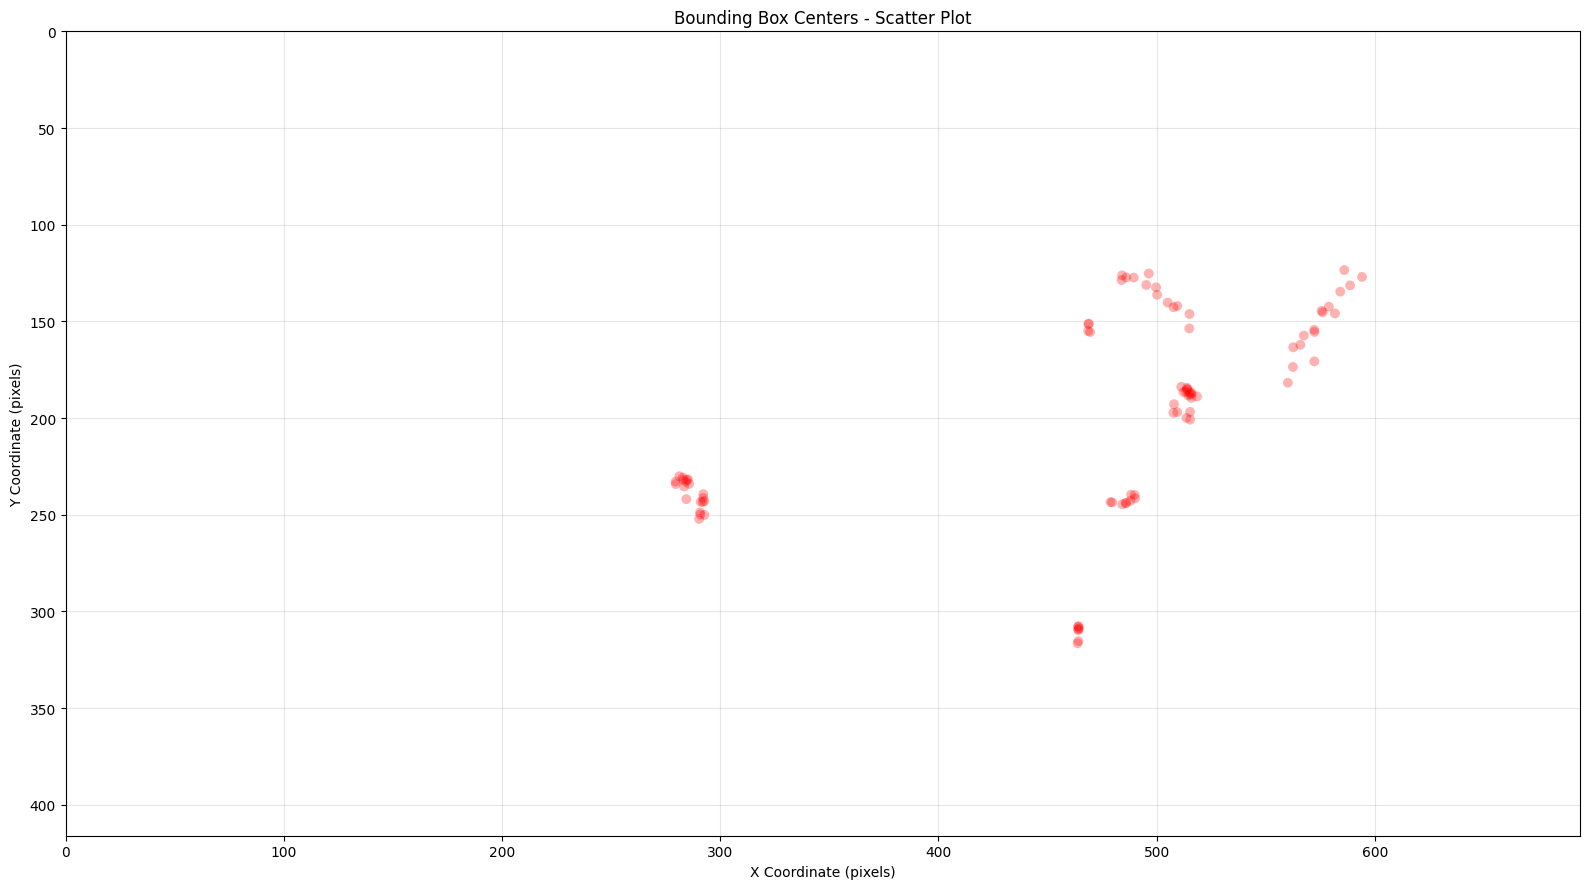

Scatter plot saved as 'scatter_plot.png'


In [ ]:
# Scatter plot com transparência
plt.figure(figsize=(16, 9))
plt.scatter(x_coords, y_coords, alpha=0.3, s=30, c='red', edgecolors='none')
plt.xlabel('X Coordinate (pixels)')
plt.ylabel('Y Coordinate (pixels)')
plt.title(f'Centros das Bounding Boxes - {data["video_name"]}\n{len(x_coords)} detecções')
plt.gca().invert_yaxis()
plt.xlim(0, frame_width)
plt.ylim(frame_height, 0)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('scatter_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Scatter plot salvo como 'scatter_plot.png'")

In [ ]:
# Estatísticas das posições
print(f"📊 Estatísticas Espaciais:")
print(f"\nCoordenadas X:")
print(f"   Média: {np.mean(x_coords):.2f}")
print(f"   Mediana: {np.median(x_coords):.2f}")
print(f"   Desvio padrão: {np.std(x_coords):.2f}")

print(f"\nCoordenadas Y:")
print(f"   Média: {np.mean(y_coords):.2f}")
print(f"   Mediana: {np.median(y_coords):.2f}")
print(f"   Desvio padrão: {np.std(y_coords):.2f}")

# Dividir frame em quadrantes e contar detecções
mid_x = frame_width / 2
mid_y = frame_height / 2

q1 = sum(1 for x, y in zip(x_coords, y_coords) if x < mid_x and y < mid_y)
q2 = sum(1 for x, y in zip(x_coords, y_coords) if x >= mid_x and y < mid_y)
q3 = sum(1 for x, y in zip(x_coords, y_coords) if x < mid_x and y >= mid_y)
q4 = sum(1 for x, y in zip(x_coords, y_coords) if x >= mid_x and y >= mid_y)

print(f"\n🔲 Detecções por Quadrante:")
print(f"   Superior Esquerdo (Q1): {q1} ({q1/len(x_coords)*100:.1f}%)")
print(f"   Superior Direito (Q2):  {q2} ({q2/len(x_coords)*100:.1f}%)")
print(f"   Inferior Esquerdo (Q3): {q3} ({q3/len(x_coords)*100:.1f}%)")
print(f"   Inferior Direito (Q4):  {q4} ({q4/len(x_coords)*100:.1f}%)")

# Visualizar quadrantes
fig, ax = plt.subplots(figsize=(10, 6))
quadrants = ['Q1\n(Sup. Esq.)', 'Q2\n(Sup. Dir.)', 'Q3\n(Inf. Esq.)', 'Q4\n(Inf. Dir.)']
counts = [q1, q2, q3, q4]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

bars = ax.bar(quadrants, counts, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Número de Detecções')
ax.set_title('Distribuição de Detecções por Quadrante')
ax.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('quadrant_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Análise estatística completa!")

## Exemplos de Uso

### Carregar vídeo específico:
```python
data = load_video_data(Path("results/bb_centers"), video_name="0a339f5d054f")
```

### Carregar todos os vídeos:
```python
data = load_video_data(Path("results/bb_centers"))
```

### Carregar arquivo antigo:
```python
x_coords, y_coords = load_from_txt(Path("bb_results.txt"))
```

### Listar todos os vídeos disponíveis:
```python
results_dir = Path("results/bb_centers")
json_files = list(results_dir.glob("*.json"))
video_names = [f.stem for f in json_files if f.stem != "summary"]
print(f"Vídeos disponíveis: {len(video_names)}")
for name in video_names[:10]:  # Mostrar primeiros 10
    print(f"  - {name}")
```

## Análise Estatística Espacial

In [ ]:
if data['confidence'] is not None:
    confidences = data['confidence']
    
    # Heatmap colorido por confiança
    plt.figure(figsize=(16, 9))
    scatter = plt.scatter(x_coords, y_coords, c=confidences, cmap='viridis', 
                         s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    plt.colorbar(scatter, label='Confiança da Detecção')
    plt.xlabel('X Coordinate (pixels)')
    plt.ylabel('Y Coordinate (pixels)')
    plt.title(f'Detecções por Nível de Confiança - {data["video_name"]}')
    plt.gca().invert_yaxis()
    plt.xlim(0, frame_width)
    plt.ylim(frame_height, 0)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('confidence_map.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Histograma de confiança
    plt.figure(figsize=(10, 6))
    plt.hist(confidences, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Confiança')
    plt.ylabel('Frequência')
    plt.title('Distribuição de Confiança das Detecções')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('confidence_histogram.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Visualizações de confiança salvas")
    print(f"   Confiança média: {np.mean(confidences):.3f}")
    print(f"   Confiança mínima: {np.min(confidences):.3f}")
    print(f"   Confiança máxima: {np.max(confidences):.3f}")
else:
    print("Dados de confiança não disponíveis (carregado de arquivo TXT)")